In [1]:
import numpy as np
import os
import time
from keras import layers, models, optimizers, callbacks, regularizers, activations, layers, initializers, utils
from keras import backend as K
from PIL import Image
from keras.layers import Dense, Input, Activation, Reshape, Add
import tensorflow as tf
import matplotlib.pyplot as plt
#from ar_capsulelayers_test import *
from scipy.io import loadmat
from sklearn.utils import shuffle
import cv2

K.set_image_data_format('channels_last')

def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = utils.to_categorical(y_train.astype('float32'))
    y_test = utils.to_categorical(y_test.astype('float32'))
#     return (x_train[:500,...], y_train[:500,...]), (x_test, y_test)
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()


Using TensorFlow backend.


In [2]:
print(x_train.shape)
x_train_padded = np.pad(x_train, ((0,0), (6,6),(6,6),(0,0)), mode='constant') 
#x_test_padded = np.pad(x_test, ((0,0), (6,6),(6,6),(0,0)), mode='constant') 
print(x_train_padded.shape)


(60000, 28, 28, 1)
(60000, 40, 40, 1)


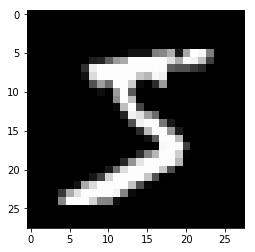

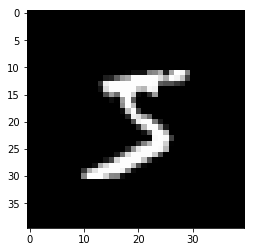

In [3]:
x_sample = x_train[0]

plt.imshow(x_sample[:,:,0], cmap='gray')
plt.show()

plt.imshow(x_train_padded[0][:,:,0], cmap='gray')
plt.show()

In [4]:
def prepare_affNIST(path):
    afftest = loadmat(path)
    afftest_images = afftest['affNISTdata']['image'][0][0].transpose()
    afftest_images = afftest_images.reshape((afftest_images.shape[0], 40, 40, 1)).astype(np.float64) /255.

    afftest_labels = afftest['affNISTdata']['label_int'][0][0].transpose()
    afftest_labels = afftest_labels.reshape((afftest_labels.shape[0])).astype(np.int64) 
    afftest_images, afftest_labels = shuffle(afftest_images, afftest_labels)
    
    return afftest_images, afftest_labels

In [5]:
x_val, y_val = prepare_affNIST('./affnist/validation.mat')
#x_test, y_test = prepare_affNIST('./affnist/test.mat')

y_val = utils.to_categorical(y_val, num_classes=10)
#y_test = utils.to_categorical(y_test, num_classes=10)



In [6]:
y_val.shape

(320000, 10)

In [12]:
from ar_capsulelayers import *

def AR_CapsNet(input_shape, args):
    dim_caps = int(args.dimcaps)
    layernum = int(args.layernum)
    print('layer num : ', layernum)
    print('dim_caps : ', dim_caps)
    
    kernel_regularizer=regularizers.l2(0)
    input_layer = Input(shape=input_shape)
    conv1 = Conv2d_bn(input_tensor = input_layer, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)
    conv1 = Conv2d_bn(input_tensor = conv1, filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer)
    
    ## Primary Capsules
    primarycaps = PrimaryCap(n_channels=8, dim_capsule=16, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(conv1)
    primarycaps = Activation('tanh')(primarycaps)
    print('primary caps shape : ', primarycaps.shape)
        
    ## Convolutional Capsules
    if layernum == 0:
        out = primarycaps
    elif layernum == 1:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        out = ConvCaps1
        
    elif layernum == 2:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        
        ConvCaps2 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps1)
        ConvCaps2 = Activation('tanh')(Add()([ConvCaps11 , ConvCaps2]))
        print('ConvCaps2 shape : ', ConvCaps2.shape)
        out = ConvCaps2
        
    elif layernum == 3:
        ConvCaps1 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = True, kernel_regularizer=kernel_regularizer)(primarycaps)
        ConvCaps1 = Activation('tanh')(ConvCaps1)
        print('ConvCaps1 shape : ', ConvCaps1.shape)
        
        ConvCaps2 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps1)
        ConvCaps2 = Activation('tanh')(Add()([ConvCaps1 , ConvCaps2]))
        print('ConvCaps2 shape : ', ConvCaps2.shape)
        
        ConvCaps3 = ConvCaps(n_channels=8, dim_capsule=dim_caps, decrease_resolution = False, kernel_regularizer=kernel_regularizer)(ConvCaps2)
        ConvCaps3 = Activation('tanh')(Add()([ConvCaps2 , ConvCaps3]))
        print('ConvCaps3 shape : ', ConvCaps3.shape)
        out = ConvCaps3
        
    ## Fully Convolutional Capsules
    output_dim_capsule = dim_caps 
    outputs = FullyConvCaps(n_channels=10, dim_capsule=output_dim_capsule, kernel_regularizer=kernel_regularizer)(out)
    outputs = Activation('tanh')(outputs)
    print('Final Routing caps shape : ', outputs.shape)
    
    ## Length Capsules
    real_outputs = Length()(outputs)
    print('Length shape : ', real_outputs.shape)

    n_class=10
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([outputs, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(outputs)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(Dense(512, activation='relu', input_dim=output_dim_capsule*n_class, kernel_regularizer=kernel_regularizer))
    decoder.add(Dense(512, activation='relu', kernel_regularizer=kernel_regularizer))
    decoder.add(Dense(np.prod(input_shape), activation='sigmoid', kernel_regularizer=kernel_regularizer))
    decoder.add(Reshape(target_shape=input_shape, name='out_recon'))

    train_model = models.Model([input_layer, y], [real_outputs, decoder(masked_by_y)])
    eval_model = models.Model(input_layer, [real_outputs, decoder(masked)])
    perturb_input_model = models.Model([input_layer, y], decoder(masked_by_y))

    # manipulate model
    noise = layers.Input(shape=(n_class, output_dim_capsule))
    noised_outputs = layers.Add()([outputs, noise])
    masked_noised_y = Mask()([noised_outputs, y])
    manipulate_model = models.Model([input_layer, y, noise], [outputs, decoder(masked_noised_y)])
    return train_model, eval_model
    
def train(train_model, x_train, y_train, args):
    valid_ratio = 0.1*int(args.validratio)
    print('valid_ratio', valid_ratio)
    
    ##########################################################################################################
    # Training without data augmentation.
    # callbacks
    class TimeHistory(callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, batch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, batch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)
    
    time_callback = TimeHistory()
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_length_1_acc',
                                           save_best_only=True, save_weights_only=False, verbose=1)
    def lr_schedule(epoch):
        lrate = 0.001
        if epoch > 50:
            lrate = 0.0005
        elif epoch > 200:
            lrate = 0.0001
        return lrate

    initial_lr = 0.005
    RMSprop = optimizers.RMSprop(lr=initial_lr, rho=0.9, epsilon=1e-08, decay=1e-4)
    train_model.compile(optimizer=RMSprop,
                      loss=[margin_loss, 'mse'],
                      loss_weights=[1., 0.3],
                      metrics=['acc'])
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: initial_lr * (0.99 ** epoch))
    
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=0,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.2,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.2,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None)

    def train_generator(x, y, batch_size):
        train_datagen = datagen  

        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    hist = train_model.fit_generator(generator=train_generator(x_train_padded, y_train, args.batch_size),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        verbose=1,
                        validation_data = [[x_val, y_val], [y_val, x_val]],
                        callbacks=[callbacks.LearningRateScheduler(lr_schedule), log, tb, checkpoint, time_callback])

    train_model.save(args.save_dir + '/trained_model.h5')
    print(time_callback.times)
    # writedata.py
    f = open(args.save_dir+'/time.txt', 'w')
    for t in time_callback.times:
        f.write(str(t)+'\n')
    f.close()

### Train

In [8]:
class args:
    epochs=2
    batch_size=100
    save_dir='./result/affnist/4'
    augment=False
    gpu=0
    dataset='cifar10'
    layernum=1
    dimcaps=16
    validratio=0
    resize=False
    debug=False

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

model, _ = AR_CapsNet(x_train_padded[0].shape, args)

print(model.summary())

train(model, x_train, y_train, args)

layer num :  1
dim_caps :  16
Instructions for updating:
Colocations handled automatically by placer.
primary caps shape :  (?, 40, 40, 16, 8)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
ConvCaps1 shape :  (?, 20, 20, 16, 8)
Final Routing caps shape :  (?, 10, 16)
Length shape :  (?, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 40,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-224d04bc0b0b>", line 21, in <module>
    train(model, x_train, y_train, args)
  File "<ipython-input-7-2cbff5b71273>", line 167, in train
    callbacks=[callbacks.LearningRateScheduler(lr_schedule), log, tb, checkpoint, time_callback])
  File "C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\keras\engine\training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\keras\engine\training_generator.py", line 217, in fit_generator
    class_weight=class_weight)
  File "C:\Users\Choi\Anaconda3\envs\py35\lib\site-packages\keras\engine\training.py", 

KeyboardInterrupt: 

### Predict

In [8]:
#x_val, y_val = prepare_affNIST('./affnist/validation.mat')
x_test, y_test = prepare_affNIST('./affnist/test.mat')

#y_val = utils.to_categorical(y_val, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)


In [13]:
class args:
    epochs=20
    batch_size=100
    save_dir='./result/affnist/1'
    augment=False
    gpu=0
    dataset='cifar10'
    layernum=1
    dimcaps=16
    validratio=0
    resize=False
    debug=False

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

model, eval_model = AR_CapsNet(x_train_padded[0].shape, args)
print(model.summary())


layer num :  1
dim_caps :  16
primary caps shape :  (?, 20, 20, 16, 8)
ConvCaps1 shape :  (?, 10, 10, 16, 8)
Final Routing caps shape :  (?, 10, 16)
Length shape :  (?, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 40, 40, 64)   640         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 40, 40, 64)   256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (No

In [17]:
model_path = './result/affnist/weights-18.h5'
eval_model.load_weights(model_path)


In [18]:
x_test.shape
x_val.shape

(320000, 40, 40, 1)

In [20]:
y_label = np.argmax(y_test, axis=1)

pred1, _ = eval_model.predict(x=x_test, batch_size=100)
print('pred1')
pred_label = np.argmax(pred1, axis=1)
acc1 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc1)


pred1
acc :  0.9163


In [9]:
model_path = './result/affnist/2/weights-18.h5'
eval_model.load_weights(model_path)

y_label = np.argmax(y_test, axis=1)

pred1, _ = eval_model.predict(x=x_test, batch_size=100)
print('pred1')
pred_label = np.argmax(pred1, axis=1)
acc1 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc1)

pred1
acc :  0.91453125


In [11]:
model_path = './result/affnist/3/weights-20.h5'
eval_model.load_weights(model_path)

y_label = np.argmax(y_test, axis=1)

pred1, _ = eval_model.predict(x=x_test, batch_size=100)
print('pred1')
pred_label = np.argmax(pred1, axis=1)
acc1 = np.sum(y_label == pred_label) / float(y_label.shape[0])
print('acc : ', acc1)

pred1
acc :  0.9158375
